<a href="https://colab.research.google.com/github/JoseEliasDuranRoa/Prediction-Models-for-Housing-Prices-in-Chennai/blob/main/ProblemSet1_Dur%C3%A1nRoa_Jos%C3%A9El%C3%ADas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Last Name:** Durán Roa


**First Name:** José Elías



---

# Problem 1: Prediction of House Prices in Chennai





## a) Data Cleaning


In [4]:
 #Connect drive
from google.colab import drive
drive.mount('/content/drive');

Mounted at /content/drive


In [30]:
%reset -f

In [31]:
#Import modules
import zipfile, os
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
pd.__version__

# Import the data
housing = pd.read_csv(zipfile.ZipFile('/content/drive/My Drive/chennai.zip').extract('Chennai_housing_sale_2.csv'), index_col=0)

#Correct data type
housing['DATE_SALE'] = pd.to_datetime(housing['DATE_SALE'], dayfirst=True)
housing['DATE_BUILD'] = pd.to_datetime(housing['DATE_BUILD'], dayfirst=True)
housing['N_BEDROOM'] = housing['N_BEDROOM'].astype('Int64')
housing['N_BATHROOM'] = housing['N_BATHROOM'].astype('Int64')
housing['AGE'] = (housing['DATE_SALE'].dt.year - housing['DATE_BUILD'].dt.year)
housing['AGE'] = housing['AGE'].astype('int64')
housing.drop(columns=['DATE_SALE', 'DATE_BUILD'], inplace=True)

* At this point, we have successfully loaded data related to housing in Chennai, a major city in India, into memory. This data is organized in a DataFrame with 21 distinct variables, which include information about property characteristics, sale prices, construction dates, and various amenities associated with the houses.

* Now, we proceed to identify and correct typos in the categorical columns of the housing dataset, such as misspelled area or zone names. Additionally, we set the categorical variable types for later manipulation.


In [32]:
# Identyfing AREA typos
housing.AREA.value_counts()
housing.BUILDTYPE.value_counts()
housing.UTILITY_AVAIL.value_counts()
housing.SALE_COND.value_counts()
housing.PARK_FACIL.value_counts()
housing.STREET.value_counts()

#Fyxing Typos
housing.AREA = housing.AREA.replace(
    {
        'Ana Nagar': 'Anna Nagar',
        'Ann Nagar': 'Anna Nagar',
        'Karapakkam': 'Karapakam',
        'Chrompt': 'Chrompet',
        'Chrmpet': 'Chrompet',
        'Chormpet': 'Chrompet',
        'KKNagar': 'KK Nagar',
        'TNagar': 'T Nagar',
        'Adyr': 'Adyar',
        'Velchery': 'Velachery'
    }
)
housing.BUILDTYPE = housing.BUILDTYPE.replace(
    {'Comercial': 'Commercial', 'Other': 'Others'}
)
housing.UTILITY_AVAIL = housing.UTILITY_AVAIL.replace(
    {'AllPub': 'All Pub', 'NoSewr': 'NoSeWa', 'NoSewr ': 'NoSeWa'}
)
housing.SALE_COND = housing.SALE_COND.replace(
    {'Ab Normal': 'AbNormal', 'PartiaLl': 'Partial', 'Partiall': 'Partial', 'Adj Land': 'AdjLand'}
)
housing.PARK_FACIL = housing.PARK_FACIL.replace('Noo', 'No')
housing.STREET = housing.STREET.replace(
    {'Pavd': 'Paved', 'NoAccess': 'No Access'}
)

#Defining categorical variables
categorical_vars = ['AREA', 'SALE_COND','PARK_FACIL','STREET','MZZONE','UTILITY_AVAIL','BUILDTYPE']
for var in categorical_vars:
   housing[var] = housing[var].astype('category')

Next, we check for missing values and display the columns that contain them. Although there are some missing values, they are not significant in number, considering the dataset contains 5,264 observations.

In [33]:
#Checking missing values
missing_values = housing.isnull().sum()
print(missing_values[missing_values > 0])

DIST_MAINROAD     8
N_BEDROOM        12
N_BATHROOM        1
QS_OVERALL       46
dtype: int64


To address the issue of missing values, we have two main options: imputation or removing the rows containing missing data. In this case, the only variable with a significant number of missing values is QS_OVERALL. To evaluate whether removing these data points would bias our distribution, we proceed by comparing the distributions of the variable QS_OVERALL between the subset of data that contains missing values and the subset without missing values.


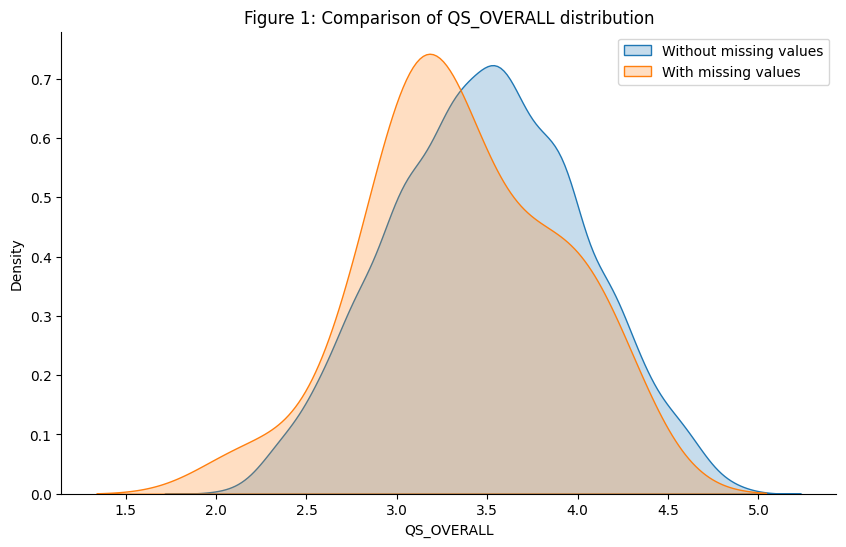

In [34]:
# Subsets of data
missing_subset = housing[housing.isnull().any(axis=1)]
non_missing_subset = housing.dropna()

plt.figure(figsize=(10, 6))
sns.kdeplot(non_missing_subset['QS_OVERALL'], label='Without missing values', fill=True)
sns.kdeplot(missing_subset['QS_OVERALL'].dropna(), label='With missing values', fill=True)
plt.legend()
plt.title('Figure 1: Comparison of QS_OVERALL distribution')
plt.xlabel('QS_OVERALL')
plt.ylabel('Density')
sns.despine()
plt.show()

To confirm the visual analysis, we use the Kolmogorov-Smirnov (KS) test to formally compare the distributions of QS_OVERALL between the two groups, supplementing the visual analysis. A lack of significant difference suggests that removing columns with missing values is unlikely to introduce bias. Hence we proceed to eliminate missing values.


In [35]:
# Kolmogorov-Smirnov (KS) test
ks_stat, p_value = ks_2samp(non_missing_subset['QS_OVERALL'], missing_subset['QS_OVERALL'].dropna())
print(f'KS Statistic: {ks_stat}, p-value: {p_value}')

KS Statistic: 0.24892350557244175, p-value: 0.12547705802858974


In [36]:
# Delete missing values
housing = housing.dropna()

### a.1) Brief Data Analysis

* The main purpose of this work is to predict housing prices using various predictors related to property characteristics and market conditions. As an initial excercise, we visualize the distribution of the target variable: sale price of the house.

In [37]:
# House prices distribution

fig = px.histogram(
    housing,
    x='SALES_PRICE',
    nbins=100,
    title='<b>Distribution of Housing Prices',
    labels={'SALES_PRICE': 'Housing Price'},
)

fig.update_layout(
    title='<b> Figure 2: House Price Distribution in Chennai',
    xaxis_title='House price (Millions)',
    yaxis_title='Frequency',
    plot_bgcolor='white',
    paper_bgcolor='white',
    font_color='black',
    bargap=0.2
)

fig.show()

The histogram depicts the distribution of house prices in Chennai. The distribution is right-skewed, meaning higher prices are less frequent, with a peak around 10 million. An interesting observation is that the market has a clear concentration in mid-range prices, while luxury properties, priced above 20 million, are significantly fewer. This pattern is quite common in real estate markets globally, where most homes fall within the affordable to mid-range bracket, and high-end properties are relatively scarce. However, compared to some cities with broader income disparities, the price range here might suggest a more evenly distributed housing market, at least within this segment.  

* We now proceed to perform a general description of the available potential predictors in the database.


In [38]:
# Generate a label dictionary for posterior data visualization

labels = {
    'PRT_ID': 'House ID',
    'AREA': 'Location',
    'INT_SQFT': 'Area (sqft)',
    'AGE': 'Age of the House',
    'DIST_MAINROAD': 'Distance to Main Road',
    'N_BEDROOM': 'Number of Bedrooms',
    'N_BATHROOM': 'Number of Bathrooms',
    'N_ROOM': 'Total Rooms',
    'SALE_COND': 'Sale Condition',
    'PARK_FACIL': 'Parking Facility',
    'BUILDTYPE': 'Building Type',
    'UTILITY_AVAIL': 'Utility Availability',
    'STREET': 'Street Condition',
    'MZZONE': 'Market Zone',
    'QS_ROOMS': 'Room Quality',
    'QS_BATHROOM': 'Bathroom Quality',
    'QS_BEDROOM': 'Bedroom Quality',
    'QS_OVERALL': 'Overall Quality',
    'REG_FEE': 'Registration Fee',
    'COMMIS': 'Commission Fee',
    'SALES_PRICE': 'Sale Price'
};

In [39]:
# Stastical Description of Data

describe_df = housing.describe()
describe_df.rename(columns=labels, inplace=True)

fig = px.imshow(
    describe_df,
    text_auto=".2f",
    aspect="auto",
    color_continuous_scale='Blues'
)

fig.update_layout(
    title="Table 1: Descriptive Statistics of Housing Data in Chennai",
    paper_bgcolor='white',
    plot_bgcolor='white',
    font=dict(size=12, color='black'),
    title_font=dict(size=16, color='black'),
    width=1000,
    height=400,
    margin=dict(l=10, r=10, t=60, b=10)
)

fig.update_traces(
    hovertemplate='Value: %{z}',
    zmin=describe_df.min().min(),
    zmax=describe_df.max().max()
)

fig.show()


Table 1 reveals interesting patterns in the housing data for Chennai. Properties exhibit a wide range in size, room count, and age, suggesting a diverse housing stock. Most homes are relatively modest in size and number of rooms. Proximity to main roads varies significantly, indicating a mix of locations, from central to more secluded areas. Financial data shows high variability in sale prices, registration fees, and commission fees, reflecting the economic diversity of the housing market.

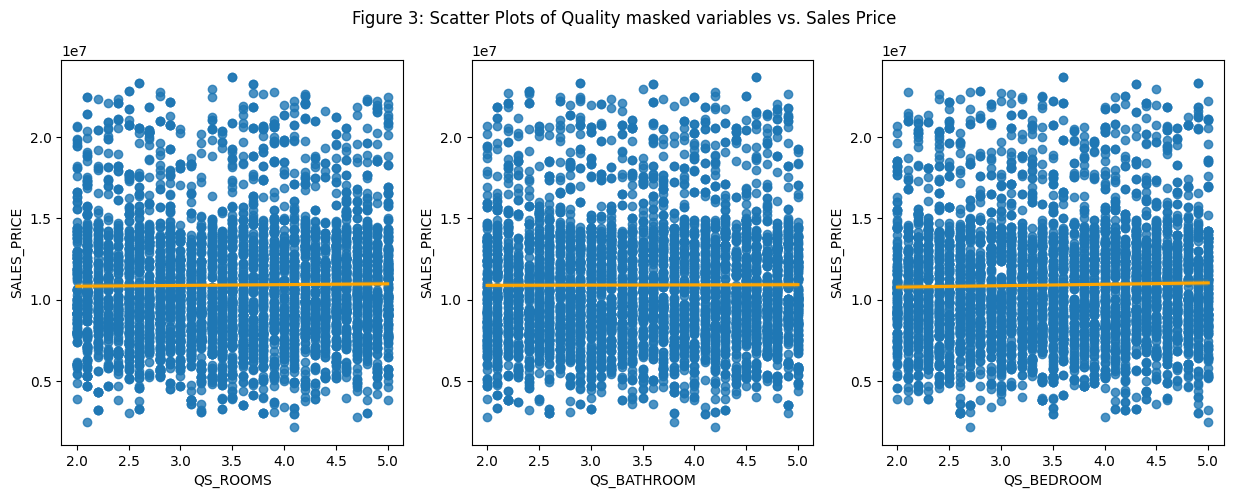

In [40]:
# We plot the masked data
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Figure 3: Scatter Plots of Quality masked variables vs. Sales Price')

# QS_ROOMS vs. SALES_PRICE
sns.regplot(x='QS_ROOMS', y='SALES_PRICE', data=housing, ax=axes[0], line_kws={'color': 'orange'})

# QS_BATHROOM vs. SALES_PRICE
sns.regplot(x='QS_BATHROOM', y='SALES_PRICE', data=housing, ax=axes[1], line_kws={'color': 'orange'})

# QS_BEDROOM vs. SALES_PRICE
sns.regplot(x='QS_BEDROOM', y='SALES_PRICE', data=housing, ax=axes[2], line_kws={'color': 'orange'})
plt.show()

 Finally, It´s important to notice that room, bathroom, and overall quality are not relevant variables; as masked data, they display variability but are not representative of actual housing quality. These are not official data points, and by design, they lack correlation with the target variable. So we proceed to eliminate them as they are not informative.

In [41]:
# Delete QS (masked) variables
housing = housing.drop(['QS_ROOMS', 'QS_BATHROOM', 'QS_BEDROOM', 'QS_OVERALL'], axis=1)

## b) Data Sampling

All categorical variables in our database are nominal, meaning they do not suggest any hierarchy or order. Therefore, we avoid using label encoding (which assigns a number to each category) since it could imply an artificial hierarchy. Instead, we apply dummy encoding, which creates a binary variable for each category while omitting one. This approach helps avoid the dummy variable trap and keeps the estimation matrix non-singular and invertible. This encoding will be used in the regressions for parts *c* and *d*. For the models in part *e* and *f*, we will use One Hot Encoding (creating one variable for each category without exclusion) to allow the construction of regression trees without omitting categories from the analysis.

In [42]:
#One Hot Encoder (For the regression tree)
cat_cols = ['AREA', 'SALE_COND', 'PARK_FACIL', 'BUILDTYPE', 'UTILITY_AVAIL', 'STREET', 'MZZONE']
housing2 = pd.get_dummies(housing, columns=cat_cols)

# Check the original categories of each variable and store them
original_categories = {}
for col in cat_cols:
    original_categories[col] = housing[col].cat.categories.tolist()  # Get categories as a list
    print(f"{col}: {original_categories[col]}");


#Dummy Encoder (for models with linear dependencies)
housing = pd.get_dummies(housing, columns=cat_cols, drop_first=True)

# Identify the omitted categories
print("Omitted categories:")
for col in cat_cols:
    if original_categories[col]:
        omitted_category = original_categories[col][0]  # The first category is omitted
        print(f"{col}: {omitted_category}")


AREA: ['Adyar', 'Anna Nagar', 'Chrompet', 'KK Nagar', 'Karapakam', 'T Nagar', 'Velachery']
SALE_COND: ['AbNormal', 'AdjLand', 'Family', 'Normal Sale', 'Partial']
PARK_FACIL: ['No', 'Yes']
BUILDTYPE: ['Commercial', 'House', 'Others']
UTILITY_AVAIL: ['All Pub', 'ELO', 'NoSeWa']
STREET: ['Gravel', 'No Access', 'Paved']
MZZONE: ['A', 'C', 'I', 'RH', 'RL', 'RM']
Omitted categories:
AREA: Adyar
SALE_COND: AbNormal
PARK_FACIL: No
BUILDTYPE: Commercial
UTILITY_AVAIL: All Pub
STREET: Gravel
MZZONE: A



To increase our predictive power, we aim to use a large number of predictors and maximize the use of the available information. In the context of machine learning, algorithms like decision trees or neural networks can handle high-dimensional data and learn complex patterns. Overfitting can be managed with techniques like regularization and cross-validation. However, to identify and discard variables that may be collinear with house prices, and as an exploratory exercise, we proceed to display a correlation analysis of all potential predictors with the target variable.

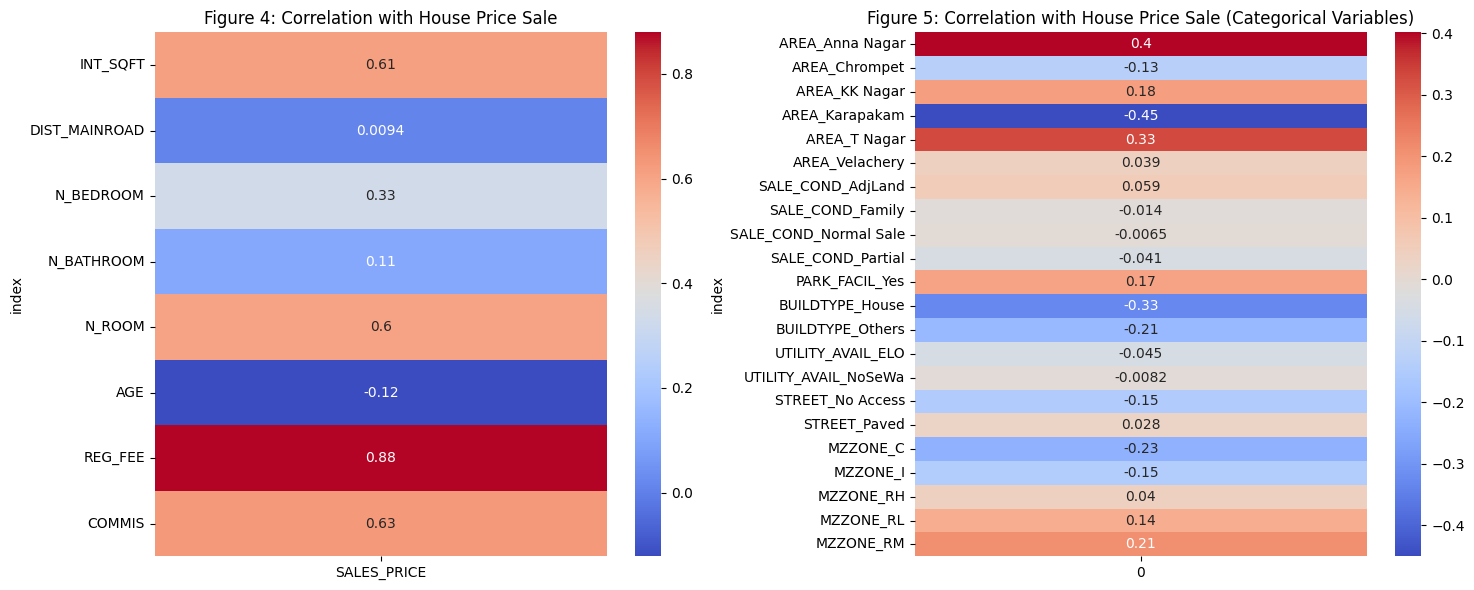

In [43]:
# Calculate and plot correlations with SALES_PRICE

# Non-boolean variables
non_bool_cols = ['INT_SQFT', 'DIST_MAINROAD', 'N_BEDROOM', 'N_BATHROOM', 'N_ROOM',
                 'AGE', 'REG_FEE', 'COMMIS', 'SALES_PRICE']

# Categorical variables
cat_cols = ['AREA_Anna Nagar', 'AREA_Chrompet', 'AREA_KK Nagar', 'AREA_Karapakam',
            'AREA_T Nagar', 'AREA_Velachery', 'SALE_COND_AdjLand', 'SALE_COND_Family',
            'SALE_COND_Normal Sale', 'SALE_COND_Partial', 'PARK_FACIL_Yes',
            'BUILDTYPE_House', 'BUILDTYPE_Others', 'UTILITY_AVAIL_ELO',
            'UTILITY_AVAIL_NoSeWa', 'STREET_No Access', 'STREET_Paved',
            'MZZONE_C', 'MZZONE_I', 'MZZONE_RH', 'MZZONE_RL', 'MZZONE_RM']

# Calculate correlations
non_bool_corr = housing[non_bool_cols].corr()['SALES_PRICE'].drop('SALES_PRICE')
cat_corr = housing[cat_cols].corrwith(housing['SALES_PRICE'])

# Plot
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.heatmap(non_bool_corr.reset_index().set_index('index'), annot=True, cmap='coolwarm', ax=axes[0])
axes[0].set_title('Figure 4: Correlation with House Price Sale')

sns.heatmap(cat_corr.reset_index().set_index('index'), annot=True, cmap='coolwarm', ax=axes[1])
axes[1].set_title('Figure 5: Correlation with House Price Sale (Categorical Variables)')

plt.tight_layout()
plt.show()


* In Figure 4, we observe that both the registration fee (REG_FEE) and the commission (COMMIS) fee have a very high correlation with the house price. It would not be methodologically correct to include them, as they are usually a percentage or some transformation of the final house price, hence collinear with the target variable. For this reason, we eliminate them from our analysis.

* The distance to the main road shows no significant correlation with house prices. However, we cannot discard that a polynomial transformation or an interaction term could reveal any relevant information with this predictor. For instance, the distance may be crucial for some type of buildings \(e.g comercial) but irrelevant for others.

* In Figure 5, neither of the two categories within the Facilities available at the location variable \(UTILITY_AVAIL\)shows a meaningful relationship with house prices, and there is no significant variation in their correlation with the omitted category. However, we choose to retain this preditor, as we are unsure of its potential relevance when interacting with other variables or for specific subgroups.

In [44]:
# Drop Comission and Registration Fee
housing.drop(columns=['REG_FEE', 'COMMIS'], inplace=True)
housing2.drop(columns=['REG_FEE', 'COMMIS'], inplace=True)

* For the linear model estimation, we include second-order polynomial terms for the house's square footage, distance to the main road, and age of the house, as these variables may have non-linear relationships with the target variable. However, we exclude quadratic terms for the number of bathrooms and bedrooms, as we do not expect significant non-linear effects. These terms are manually incorporated for both the linear and regression tree dataframes \(housing and housing2 \).

In [45]:
# Create polynomial features for continuous variables in housing
continuous_vars = ['INT_SQFT', 'DIST_MAINROAD', 'AGE']
for var in continuous_vars:
  housing[var + '_squared'] = housing[var] ** 2

# Create polynomial features for continuous variables in housing2
for var in continuous_vars:
  housing2[var + '_squared'] = housing2[var] ** 2

* Now we proceed to define a Pandas serie with the target variable and a Pandas data frame with the selected relevant predictors. Posteriorly we split our sample into test and training data.

In [46]:
# Define testing and training samples
y = housing['SALES_PRICE']
X = housing.drop(columns=['SALES_PRICE'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=642815553)

## c) Linear Model Estimation




In [47]:
# First we run a simple OLS without polynomials and interactions
lm = LinearRegression()
lm.fit(X_train, y_train)

#Coefficients
print(f'Interc. = {lm.intercept_}')
print(f'Coef.   = {lm.coef_}')

# Metrics
y_test_pred = lm.predict(X_test)
print(f'R2= {r2_score(y_test, y_test_pred)}')
print(f'MAE= {mean_absolute_error(y_test, y_test_pred)}')
print(f'RMSE= {mean_squared_error(y_test, y_test_pred, squared = False)}')

Interc. = 6924531.713715332
Coef.   = [ 4.68823636e+03 -3.91297680e+02  4.21224811e+05 -3.71264296e+05
  9.03215887e+04 -1.34168130e+04  1.75901432e+06 -4.41777995e+05
 -2.10392282e+06 -2.31311740e+06  1.88236135e+06 -1.65467662e+06
  4.08987396e+05 -9.14744492e+04 -5.50338653e+03 -2.58034996e+05
  1.02824325e+06 -4.66233082e+06 -3.95707621e+06 -3.48525775e+05
 -2.05349436e+05 -1.12822030e+06 -4.53005557e+05  5.30027778e+05
  1.01790037e+06  1.65272246e+06  2.26944800e+06  2.92948886e+06
 -3.50637857e-01  1.09237983e+00 -1.34485245e+02]
R2= 0.9568964983442791
MAE= 589025.9022706053
RMSE= 790945.7565515913


* To interpret the regression metrics and assess model performance, it is crucial to have a point of comparison. Predictive metrics such as \( R^2 \), RMSE, and MAE cannot be fully understood in isolation; while the \( R^2 \) appears high (explaining 95.6% of the variance), it is necessary to compare with alternative models performances in further points.



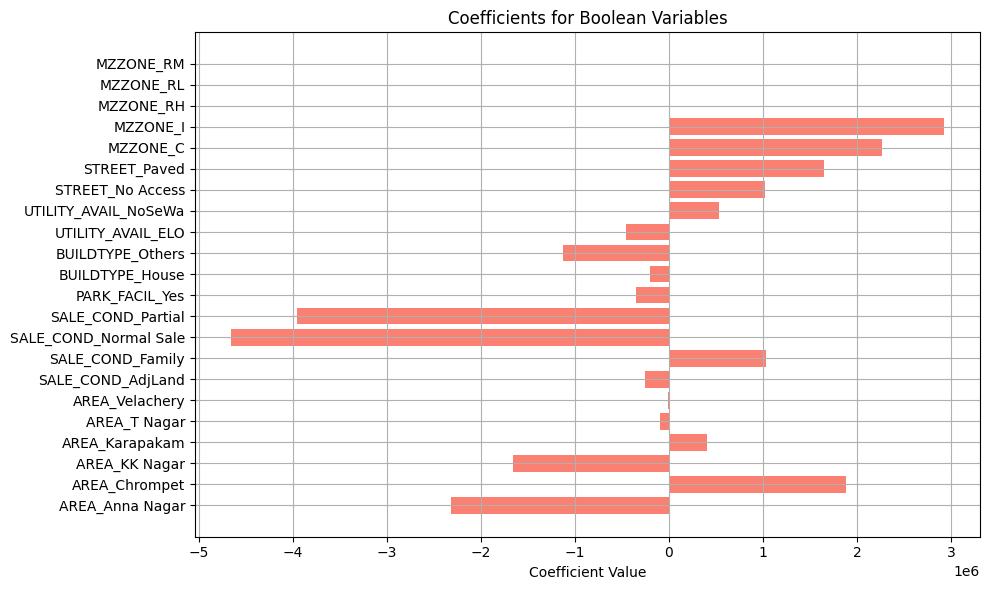

In [52]:
#Graph of coefficients
continuous_vars = ['INT_SQFT', 'DIST_MAINROAD', 'N_BEDROOM', 'N_BATHROOM', 'N_ROOM', 'AGE',
                   'INT_SQFT_squared', 'DIST_MAINROAD_squared', 'AGE_squared']
boolean_vars = ['AREA_Anna Nagar', 'AREA_Chrompet', 'AREA_KK Nagar', 'AREA_Karapakam', 'AREA_T Nagar',
                'AREA_Velachery', 'SALE_COND_AdjLand', 'SALE_COND_Family', 'SALE_COND_Normal Sale',
                'SALE_COND_Partial', 'PARK_FACIL_Yes', 'BUILDTYPE_House', 'BUILDTYPE_Others',
                'UTILITY_AVAIL_ELO', 'UTILITY_AVAIL_NoSeWa', 'STREET_No Access', 'STREET_Paved',
                'MZZONE_C', 'MZZONE_I', 'MZZONE_RH', 'MZZONE_RL', 'MZZONE_RM']

# Extract coefficients directly
coef_dict = dict(zip(continuous_vars + boolean_vars, lm.coef_))

# Separate coefficients into continuous and boolean
continuous_coefficients = [coef_dict[var] for var in continuous_vars]
boolean_coefficients = [coef_dict[var] for var in boolean_vars]

# Plot boolean variables
plt.figure(figsize=(10, 6))
plt.barh(boolean_vars, boolean_coefficients, color='salmon')
plt.xlabel('Coefficient Value')
plt.title('Coefficients for Boolean Variables')
plt.grid(True)
plt.tight_layout()
plt.show()

**Analysis of the coefficients:**
<br> <br>
1) *Categorical Variables:*

* The market zone is important in determining housing prices. Living in RM (MZZONE_RM) increases the price by 2.93 million, reflecting the high demand and better infrastructure typical of premium urban areas. RL (MZZONE_RL) and RH (MZZONE_RH) also have higher prices, with increases of 2.27 million and 1.65 million, respectively. This correlation is relevant considering the average house price of 10.9 million.
<br> <br>
* The area of the property (AREA) is just as relevant as the market zone when it comes to determining housing prices. This is due to several factors: (1) better infrastructure and urban planning tend to drive up property values, (2) proximity to key amenities increases desirability, (3) accessibility to transportation hubs adds value by reducing commuting times, and (4) social prestige of certain neighborhoods leads to higher demand and prices. In general, areas like T Nagar and Anna Nagar see higher prices, while areas such as Karapakam, KK Nagar, and Velachery are associated with lower prices, reflecting the varying desirability of these locations.
<br> <br>
* The type of property is strongly linked to its price. The omitted category is commercial properties, which are more valuable compared to residential buildings. Specifically, properties categorized as houses (BUILDTYPE_House) see a price decrease of 4.66 million, while other building types (BUILDTYPE_Others) have a smaller reduction of 3.96 million. This suggests that commercial properties are generally priced higher in this market.
<br> <br>
* Properties sold under conditions like "AdjLand" tend to have higher prices, while those sold under more typical conditions, such as "Normal Sale," show slightly reduced prices. On the other hand, properties sold under "Family" or "Partial" conditions experience more substantial price drops, suggesting that the sale circumstances can greatly influence property values.
<br><br>
* Regarding utilities, homes without essential services like sewage or electricity (e.g., "NoSeWa" or "ELO") are much less valuable compared to those with full utility availability. Lastly, street accessibility plays a crucial role—properties with no street access are severely penalized, while paved streets, though still negative, result in smaller price reductions compared to gravel or poorly accessible streets.






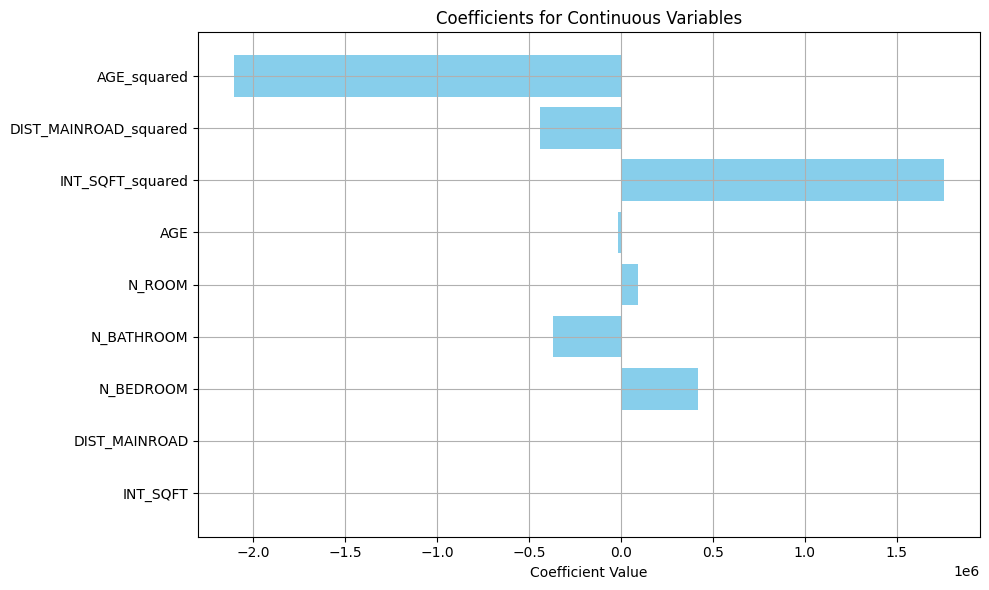

In [51]:
# Plot continuous variables
plt.figure(figsize=(10, 6))
plt.barh(continuous_vars, continuous_coefficients, color='skyblue')
plt.xlabel('Coefficient Value')
plt.title('Coefficients for Continuous Variables')
plt.grid(True)
plt.tight_layout()
plt.show()

2) *Continous Variables:*

* Property size in square feet positively impacts sale price, though with diminishing returns. Each additional square foot adds 4,688 units to the price. A 10-square-meter (107-square-foot) increase raises the price by about 500,000 units—a moderate addition given the overall price scale in millions. This trend is moderated by the squared variable, indicating that the price increase per square foot decreases as the property size grows.
<br><br>
* The total count of bedrooms and bathrooms has one of the largest impacts among the continuous variables. Each additional bedroom or bathroom adds approximately 421,225 units to the sale price, making these features highly valuable. This aligns with homebuyers’ preferences, where more rooms typically enhance a property’s appeal and market value.
<br><br>
* Although the total room count has a positive effect, its impact is smaller than the combined bedrooms and bathrooms count, adding about 90,321 units per additional room. This implies that, while valuable, additional rooms have a smaller effect on the price compared to specific rooms like bedrooms and bathrooms.
<br><br>
* The age of the house has a negative effect, indicating depreciation. Each additional year reduces the sale price by approximately 13,417 units. This effect is more pronounced for older properties, as indicated by AGE_squared, which suggests that the negative impact on price increases with the property’s age.
<br><br>
* Distance to the main road has a very minor impact on the sale price. Each kilometer farther from the main road reduces the price by only 391 units, which is nearly negligible relative to the average sale price of 10.9 million units. This suggests that proximity to the main road is not a substantial factor in determining property value, especially when compared to other features like property size or room count.

## d) Lasso estimation


* Note that if we wanted to interpret the coefficients of the predictors directly, we would need to standardize only the continuous variables during preprocessing, leaving the boolean and dummy variables unstandardized. This would allow us to interpret each dummy coefficient as the monetary differential impact on prices relative to the omitted category. However, since our main focus is on predictive power, we will not make this distinction.

* Also note que los límites del grid no se definen de manera arbitraria, por simplicidad computacional al replicar el código se itera el grid search en un intervalo muy pequeño alrededor del valor óptimo (que fue encontrado modificando y narrowing the limits more than one time)

In [53]:
# Model fitting
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

# Prepare an object for Cross-Validation
cv=KFold(n_splits=10, shuffle = True, random_state=123)

# Preprocessing
steps = [ ('scale', StandardScaler()), ('poly', PolynomialFeatures(1)), ('LASSO', Lasso()) ]
pipe  = Pipeline(steps)

# Define a grid for the hyperparameter value
grid = dict()
grid['LASSO__alpha'] = np.arange(350, 400, 2)
search = GridSearchCV(pipe, grid, scoring='neg_root_mean_squared_error', cv=cv)
results = search.fit(X_train, y_train)

print(f'RMSE: {-results.best_score_}')
print(f'Config: {results.best_params_}')

RMSE: 761453.1236717419
Config: {'LASSO__alpha': 396}


In [ ]:
## Fit using *optimal* hyperparameter and FULL TRAINING sample
from sklearn.linear_model import Lasso
steps = [('scale', StandardScaler()), ('poly', PolynomialFeatures(1)), ('lasso', Lasso(alpha=1.2))]
pipe  = Pipeline(steps)
pipe.fit(X_train, y_train)

print(pipe[2].coef_)
print(pipe[2].intercept_)

## Compute metrics in testing sample
y_test_pred = pipe.predict(X_test)

from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
print(f'RMSE:{root_mean_squared_error(y_test, y_test_pred)}')
print(f'MAE:{mean_squared_error(y_test, y_test_pred)}')

[ 0.00000000e+00  2.15073051e+06 -2.28309951e+04  3.40600549e+05
 -1.51055203e+05  9.23873805e+04 -1.64370796e+05  5.62528667e+05
 -1.88622086e+05 -7.44975972e+05 -9.01698452e+05  4.71290652e+05
 -5.51460938e+05  1.61805763e+05 -3.73584521e+04 -2.17162229e+03
 -1.03248238e+05  5.14095790e+05 -2.21639590e+06 -1.86113121e+06
 -1.43955778e+05 -1.02664863e+05 -5.03082280e+05 -2.18356802e+05
  1.42434872e+05  2.65417401e+05  7.32506368e+05  9.78367472e+05
  1.28040870e+06 -4.62089796e+05  1.31321235e+04 -8.78804230e+04]
10866028.654713845
RMSE:790945.561378763
MAE:625594881064.7666


## e) Regression Tree Model



In [ ]:
# Define testing and training with One Hot Enconder database

y2 = housing2['SALES_PRICE']
X2 = housing2.drop(columns=['SALES_PRICE'])

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=642815553)


* To select the optimal number of samples per leaf in a decision tree, values from 2 to 9 are tested, training the model and recording RMSE and MAE on test predictions for each setting. Prioritizing RMSE, as it penalizes larger errors, allows us to focus on minimizing significant deviations in house price predictions. This process identifies the configuration that best balances model accuracy and complexity. I plot the error trends to highlight the optimal choice (4).

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



min_samples_leaf: 2 -> RMSE: 586454.6433, MAE: 353116.5511
min_samples_leaf: 3 -> RMSE: 595195.1235, MAE: 395308.5469


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



min_samples_leaf: 4 -> RMSE: 625517.1348, MAE: 434077.1416


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



min_samples_leaf: 5 -> RMSE: 620019.7664, MAE: 457608.1425


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



min_samples_leaf: 6 -> RMSE: 647180.7187, MAE: 481321.3473


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



min_samples_leaf: 7 -> RMSE: 649132.7517, MAE: 497414.0613
min_samples_leaf: 8 -> RMSE: 667654.9827, MAE: 514940.4138


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



min_samples_leaf: 9 -> RMSE: 697912.3521, MAE: 541448.7959

Optimal min_samples_leaf: 2 with RMSE: 586454.6433


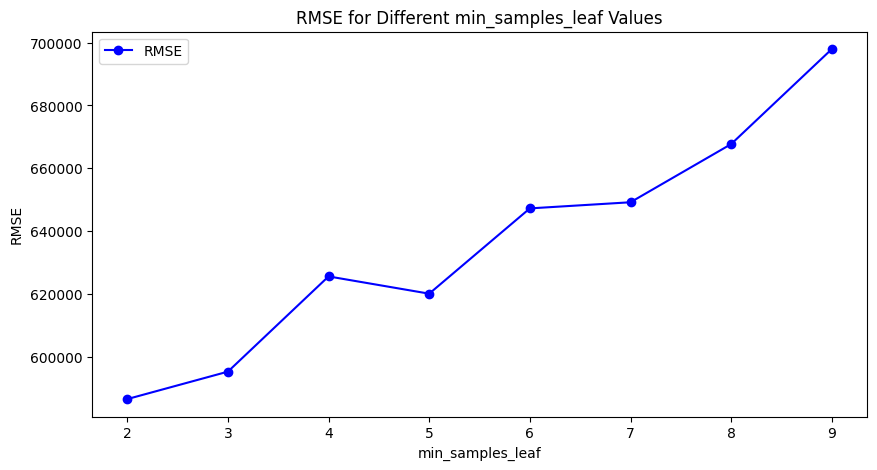

In [ ]:
from sklearn import tree

# Define the range of min_samples_leaf values
min_samples_leaf_values = range(2, 100)

# Initialize variables to store RMSE and MAE results
rmse_results = []
mae_results = []
best_rmse = float("inf")
optimal_min_leaf = None
best_model = None

# Loop through each min_samples_leaf value
for min_leaf in min_samples_leaf_values:
    # Define tree object with varying min_samples_leaf
    treereg = tree.DecisionTreeRegressor(min_samples_leaf=min_leaf, ccp_alpha=0.005)

    # Fit tree model
    treereg.fit(X_train2, y_train2)

    # Predict on testing data
    y_test_pred2 = treereg.predict(X_test2)

    # Calculate RMSE and MAE
    rmse = mean_squared_error(y_test2, y_test_pred2, squared=False)
    mae = mean_absolute_error(y_test2, y_test_pred2)

    # Append metrics to lists
    rmse_results.append(rmse)
    mae_results.append(mae)

    # Update optimal model if current RMSE is lower than the best observed so far
    if rmse < best_rmse:
        best_rmse = rmse
        optimal_min_leaf = min_leaf
        best_model = treereg  # Save the best model

    # Print results for each min_samples_leaf value
    print(f'min_samples_leaf: {min_leaf} -> RMSE: {rmse:.4f}, MAE: {mae:.4f}')

# Display the optimal min_samples_leaf value and corresponding RMSE
print(f"\nOptimal min_samples_leaf: {optimal_min_leaf} with RMSE: {best_rmse:.4f}")

# Plot the RMSE values across different min_samples_leaf values
plt.figure(figsize=(10, 5))
plt.plot(min_samples_leaf_values, rmse_results, marker='o', color='b', label='RMSE')
plt.xlabel('min_samples_leaf')
plt.ylabel('RMSE')
plt.title('RMSE for Different min_samples_leaf Values')
plt.legend()
plt.show()

* Now that we have the optimal minimum sample size per leaf for our decision tree, we plot the tree structure to visually interpret how features like square footage, number of bedrooms, and location contribute to predicting house prices.

IndexError: list index out of range

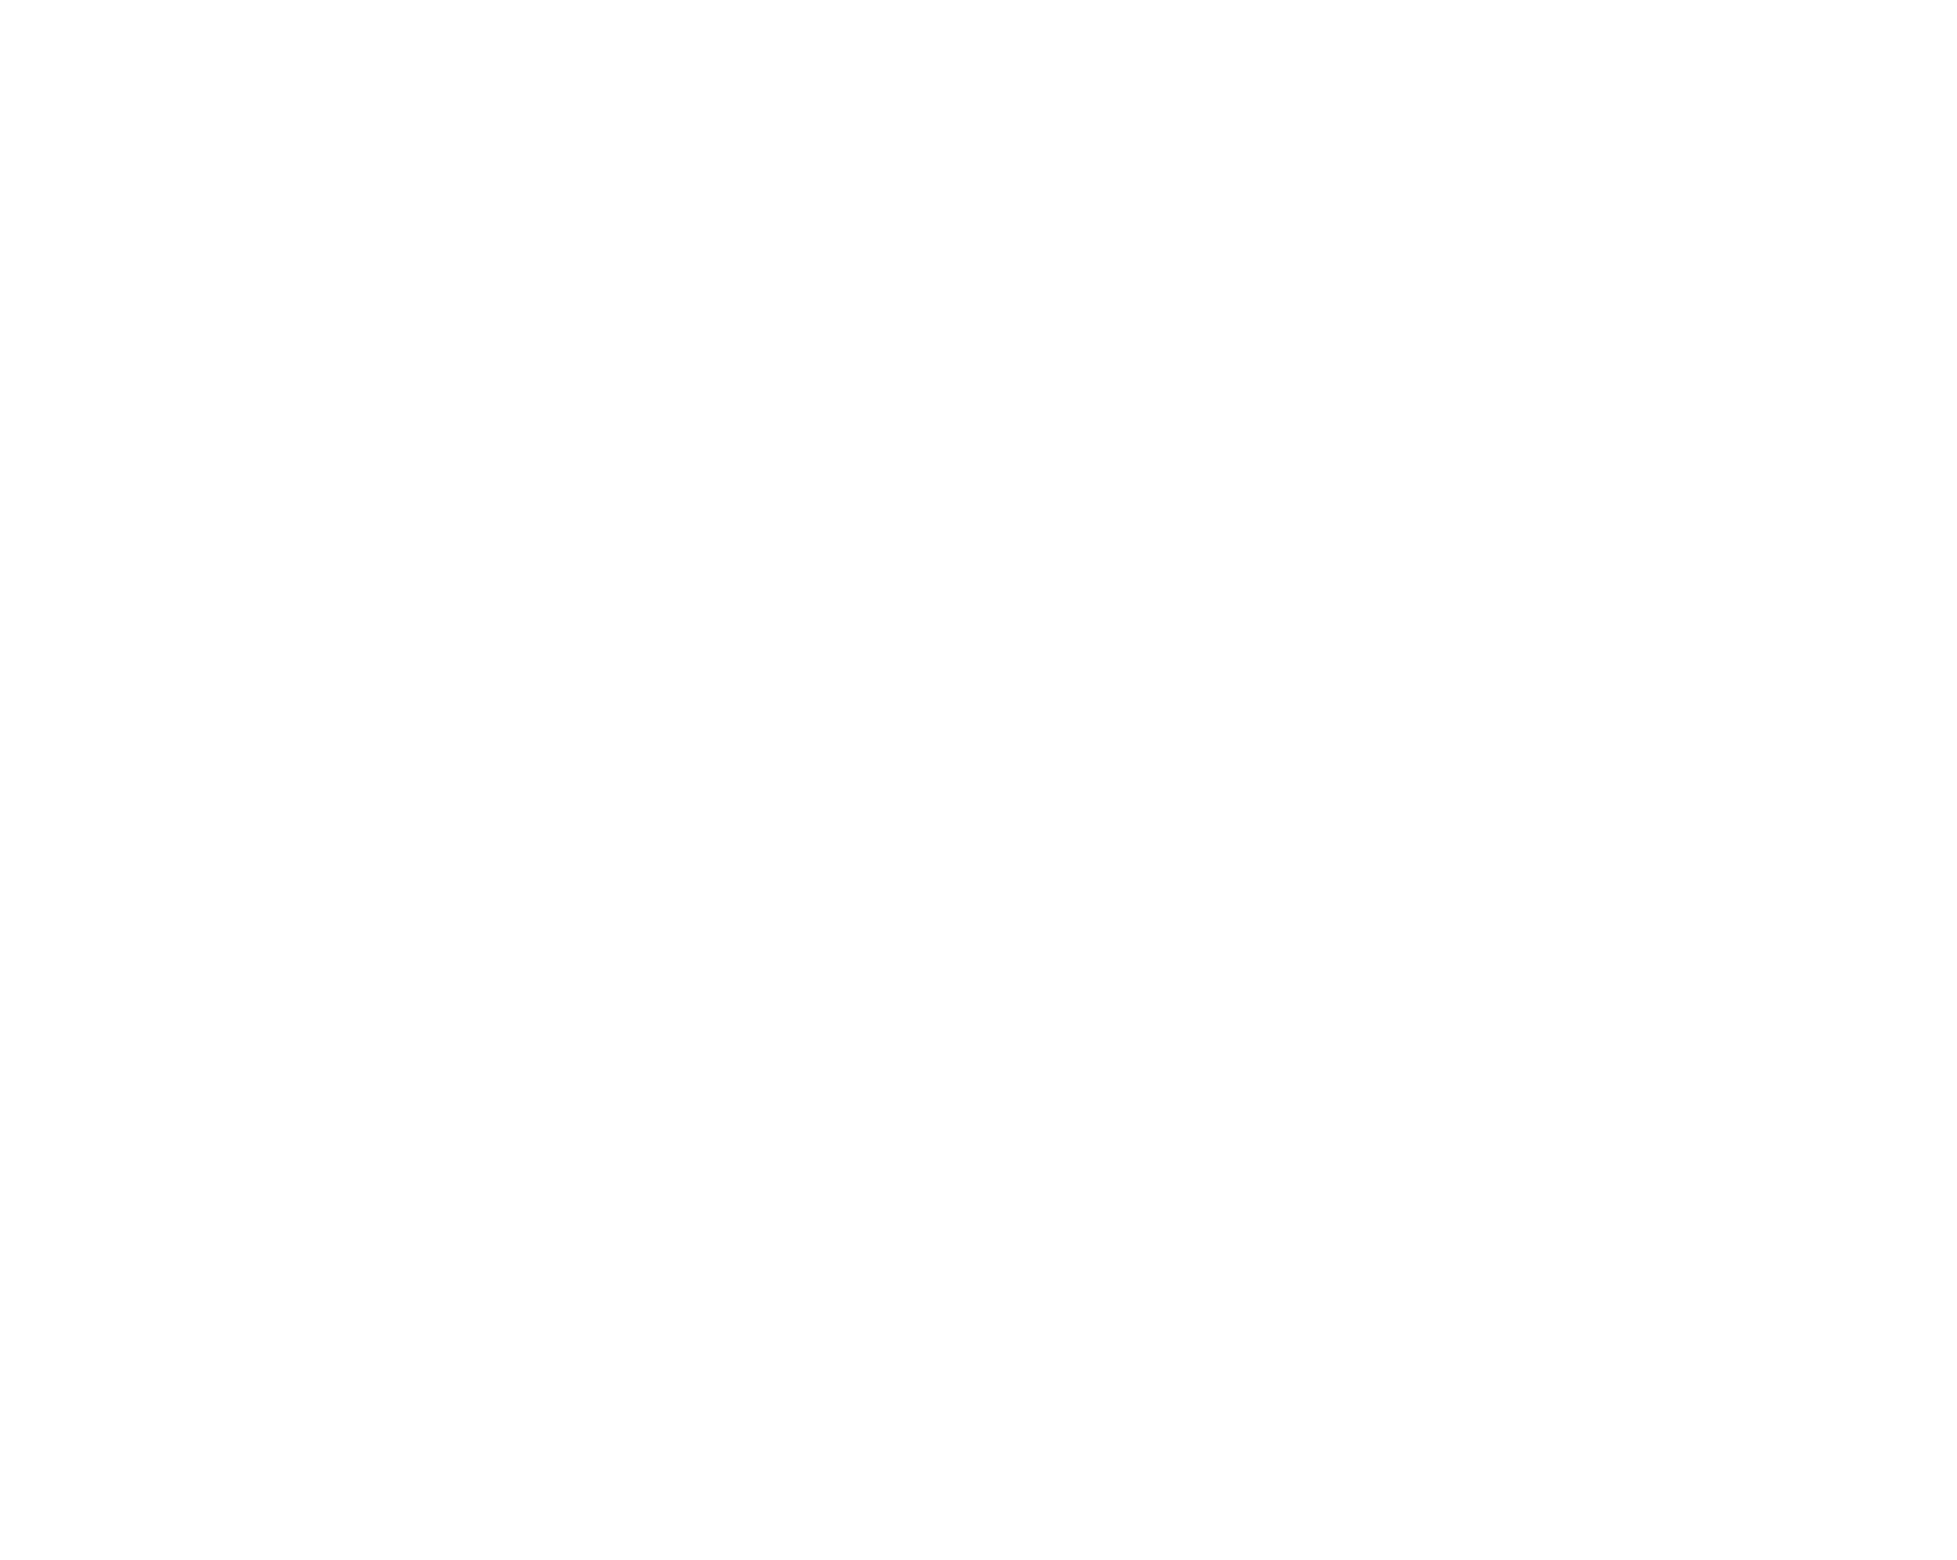

In [ ]:
# Plot the decision tree for the optimal model
X_names = ['INT_SQFT', 'N_BEDROOM', 'N_BATHROOM', 'N_ROOM', 'REG_FEE', 'COMMIS', 'SALES_PRICE', 'AGE', 'AREA_Anna Nagar', 'AREA_Chrompet', 'AREA_KK Nagar', 'AREA_Karapakam', 'AREA_T Nagar', 'AREA_Velachery', 'SALE_COND_AdjLand', 'SALE_COND_Family', 'SALE_COND_Normal Sale', 'SALE_COND_Partial', 'PARK_FACIL_Yes', 'BUILDTYPE_House', 'BUILDTYPE_Others', 'STREET_No Access', 'STREET_Paved', 'MZZONE_C', 'MZZONE_I', 'MZZONE_RH', 'MZZONE_RL', 'MZZONE_RM']

fig = plt.figure(figsize=(25, 20))
tree.plot_tree(best_model, feature_names=X_names, filled=True)
plt.show()

* Is intuitive to develop a regression tree with a heavy set of dummies? How this ffects interpretability and utility of results?



In [ ]:
# Get importance
importance = pd.Series(treereg.feature_importances_).sort_values(ascending=False)

# Create a DataFrame to summarize feature importance
importance_df = pd.DataFrame({
    'Feature': [X_names[i] for i in importance.index],
    'Importance': importance.values
})

# Display the DataFrame as a table
importance_df

IndexError: list index out of range

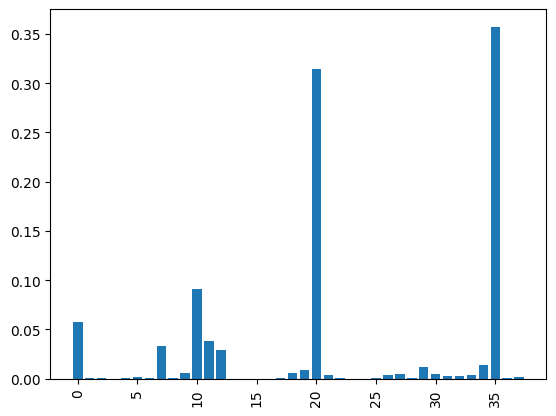

In [ ]:
# Plot importance
plt.bar(importance.index, importance)
plt.xticks(rotation='vertical')
plt.show()

* Interpretation. We proceed to graph.
* QUESTION: Why REG-FEE is so relevant here and previously was not?


## f) Random Forest

* Estimate a random forest model using the pre-processing steps that you consider necessary. Note that you must choose the optimal value of the hyperparameters by cross-validation before estimating the best model. You can focus on tuning either `min_samples_leaf` or `max_features`, but you should try a few of the other one.

* Show in a table the variable importance according to this model (you can also provide a figure if you want). Comment on the results.

* Obtain the RMSE and the MAE as metrics of predictive performance of the model.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Initialize and train the Random Forest Regressor
RFreg = RandomForestRegressor(n_estimators=100,
                              min_samples_leaf=5,
                              max_features='sqrt',
                              random_state=123).fit(X_train2, y_train2)

# Make predictions and evaluate model performance using RMSE
y_test_pred2 = RFreg.predict(X_test2)
print(f'RMSE: {root_mean_squared_error(y_test2, y_test_pred2)}')
print(f'MAE:{mean_squared_error(y_test2, y_test_pred2)}')

RMSE: 603168.806712459
MAE:363812609390.93164


In [ ]:
# Calculate feature importances
importance = pd.Series(RFreg.feature_importances_).sort_values(ascending=False)

# Create a DataFrame for better display
importance_df = pd.DataFrame({
    'Feature': [X_names[i] for i in importance.index],
    'Importance': importance.values
})

importance_df

IndexError: list index out of range

In [ ]:
# Plotting the feature importances
importance = pd.Series(RFreg.feature_importances_).sort_values(ascending=False)
importance.index = [X_names[i] for i in importance.index]

plt.bar(importance.index, importance)
plt.xticks(rotation='vertical')
plt.show()

IndexError: list index out of range


> Your comments here


## g) Discussion

Finally, discuss which prediction model is the best one. Also, briefly comment on any other key insights you can learn from one or more of these models.


* TABLA CON RMSE Y MAE de las 4 regresiones.


---

# Problem 2: Financial Investment

* This problem is **optional**. Completing it will give you 1 extra point.

* We are interested in estimating the effect of participation in 401(k) pension plans on employees’ net financial assets. The dataset [pension.csv](https://raw.githubusercontent.com/albarran/00datos/refs/heads/main/pension.csv) contains information about net financial assets (*net_tfa*) and participation in a 401(k) plan (*p401*), along with several additional individual characteristics: age, income, education, family size, marital status, having two earners in the household, having a defined benefit (DB) pension (a type of retirement plan where an employer guarantees a specified retirement amount), participation in an IRA (Individual Retirement Account, a type of retirement savings account with tax advantages), and homeownership. You can find more information about the variables [here](https://search.r-project.org/CRAN/refmans/hdm/html/pension.html).

* Since saving preferences (which are unobservable) can directly affect net asset holdings and the decision to participate, and may also be correlated with observable characteristics (e.g., income), participation in 401(k) plans can be endogenous. However, it is possible to exploit randomness (conditional on confounding variables) in eligibility for 401(k) plans (*e401*). An instrumental variable (IV) approach could be used to estimate the causal effect, but in this case, we will focus on estimating the intention-to-treat effect.


* Load the data and check the variables types.

In [ ]:
# Load the dataset from the provided URL
url = 'https://raw.githubusercontent.com/albarran/00datos/refs/heads/main/pension.csv'
pension_data = pd.read_csv(url)

# Display data types of each variable
print(pension_data.dtypes)

ira           int64
a401          int64
hval          int64
hmort         int64
hequity       int64
nifa          int64
net_nifa      int64
tfa           int64
net_tfa       int64
tfa_he        int64
tw            int64
age           int64
inc           int64
fsize         int64
educ          int64
db            int64
marr          int64
male          int64
twoearn       int64
dum91         int64
e401          int64
p401          int64
pira          int64
nohs          int64
hs            int64
smcol         int64
col           int64
icat          int64
ecat          int64
zhat        float64
net_n401      int64
hown          int64
i1            int64
i2            int64
i3            int64
i4            int64
i5            int64
i6            int64
i7            int64
a1            int64
a2            int64
a3            int64
a4            int64
a5            int64
dtype: object


## a) Linear Model Estimation


* Estimate using OLS a model to examine the effect of 401(k) eligibility on asset holdings, controlling for relevant confounding factors.

* Carefully consider how each variable should enter the model (e.g., whether education should be treated as a continuous or categorical variable). Additionally, consider whether polynomial terms or interaction effects might be useful. There is no universally correct choice, but your decisions should be justified and applied consistently throughout the analysis.

* Show the estimated intention-to-treat effect and its standard error and other relevant information to comment on the evidence on the results.

In [ ]:
# Check for missing values
missing_values = pension_data.isnull().sum()

* The dataset contains 9,915 observations with no missing values across all variables

In [ ]:
# Summary statistics
summary_statistics = pension_data.describe()

# Display the results
print(summary_statistics)

                 ira           a401           hval          hmort  \
count    9915.000000    9915.000000    9915.000000    9915.000000   
mean     3462.871609    3990.459304   63595.865759   30022.505093   
std      9648.027853   12825.840676   73679.374267   40056.879558   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000   48000.000000    7000.000000   
75%         0.000000     200.000000   95000.000000   50000.000000   
max    100000.000000  153000.000000  300000.000000  150000.000000   

             hequity          nifa      net_nifa           tfa       net_tfa  \
count    9915.000000  9.915000e+03  9.915000e+03  9.915000e+03  9.915000e+03   
mean    33573.360666  1.392864e+04  1.041415e+04  2.156603e+04  1.805153e+04   
std     51830.770524  5.490488e+04  5.602886e+04  6.256504e+04  6.352250e+04   
min    -40000.000000  0.000000e+00 -5.023020e+05  0.000000

* Summary statistics indicate that the average net financial assets (net_tfa) stand at approximately \$18,051, with a minimum of -\$502,302, highlighting potential financial distress among some participants. The demographic overview reveals a mean age of 34.7 years and an average income of $39,000, suggesting a relatively young and economically diverse population.

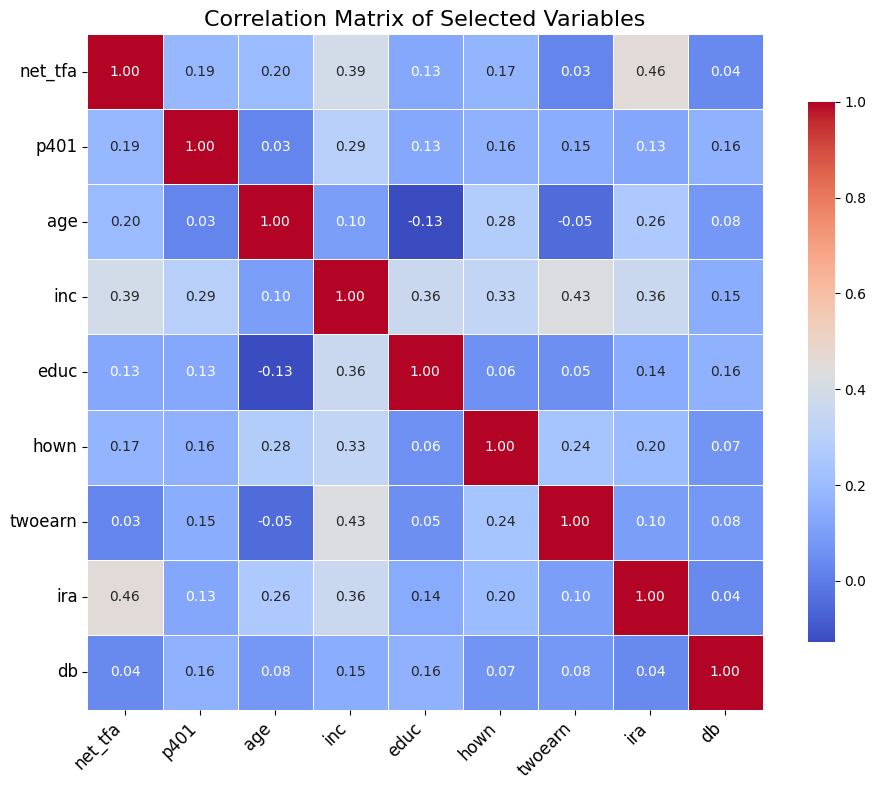

Correlation between p401 and net_tfa: 0.18939639212381043


In [ ]:
# Select relevant variables
selected_columns = ['net_tfa', 'p401', 'age', 'inc', 'educ', 'hown', 'twoearn', 'ira', 'db']
subset_data = pension_data[selected_columns]

# Calculate correlation matrix
correlation_matrix = subset_data.corr()
plt.figure(figsize=(10, 8))

# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})

plt.title('Correlation Matrix of Selected Variables', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.show()

# Step 6: Examine specific correlations of interest
p401_corr = correlation_matrix['net_tfa']['p401']
print(f"Correlation between p401 and net_tfa: {p401_corr}")

* The correlation coefficient of approximately 0.19 between participation in the 401(k) plan (p401) and net financial assets (net_tfa) indicates a weak positive relationship. This suggests that higher participation in 401(k) plans is associated with higher net financial assets, but the correlation is not strong enough to imply a direct or significant causal relationship.

In [ ]:
# Import necessary libraries
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Define features (X) and target variable (y)
X = pension_data[['e401', 'age', 'inc', 'educ', 'hown', 'twoearn', 'ira', 'db']]
y = pension_data['net_tfa']

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the OLS model
lm = LinearRegression()
lm.fit(X_train, y_train)

# Coefficients and Intercept
print(f'Intercept: {lm.intercept_}')
print(f'Coefficients: {lm.coef_}')

# Predictions
y_test_pred = lm.predict(X_test)

# Metrics
print(f'R²: {r2_score(y_test, y_test_pred)}')
print(f'MAE: {mean_absolute_error(y_test, y_test_pred)}')
print(f'RMSE: {mean_squared_error(y_test, y_test_pred, squared=False)}')

Intercept: -27630.917505298592
Coefficients: [ 5.45612463e+03  4.16369119e+02  8.71934499e-01 -4.22901704e+02
  1.36761939e+03 -2.03556926e+04  2.27935061e+00 -4.14421054e+03]
R²: 0.24512525559523024
MAE: 20345.035600779676
RMSE: 49876.47472329205


* **MISSING INTERPRETATION**


## b) Lasso Estimation

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Model fitting and hyperparameter tuning
search = GridSearchCV(
    Pipeline([
        ('scale', StandardScaler()),
        ('poly', PolynomialFeatures(degree=1)),
        ('lasso', Lasso())
    ]),
    param_grid={'lasso__alpha': np.arange(1, 5000, 5)},
    scoring='neg_root_mean_squared_error',
    cv=10
)

# Fit the model
search.fit(X_train, y_train)

# Output best score and configuration
print(f'RMSE (Cross-Validation): {-search.best_score_}')
print(f'Optimal Hyperparameters: {search.best_params_}')

# Fit using optimal hyperparameter on the full training sample
best_lasso = search.best_estimator_
print("LASSO Coefficients:")
print(best_lasso.named_steps['lasso'].coef_)
print(f'Intercept: {best_lasso.named_steps["lasso"].intercept_}')

# Predictions and metrics in the testing sample
y_test_pred = best_lasso.predict(X_test)

# Compute metrics
print(f'RMSE (Testing Sample): {np.sqrt(mean_squared_error(y_test, y_test_pred))}')
print(f'MAE (Testing Sample): {mean_absolute_error(y_test, y_test_pred)}')
print(f'R² (Testing Sample): {r2_score(y_test, y_test_pred)}')

RMSE (Cross-Validation): 52337.53705167878
Optimal Hyperparameters: {'lasso__alpha': 691}
LASSO Coefficients:
[    0.          1866.20177347  4119.6929107  20260.38875867
   -87.40786379   185.29944159 -8493.50521989 21474.62298047
  -995.10030672]
Intercept: 18090.623171961677
RMSE (Testing Sample): 49738.62258724696
MAE (Testing Sample): 19848.846603291753
R² (Testing Sample): 0.24929224176748122


## c) Double Selction LASSO

* Repeat the part a) again but using Double-selection LASSO.

* Comment on the differences with the previous results and discuss your overall conclusion about the evidence.

In [ ]:
# Your code here


> Your comments here


## d)

* Finally repeat the estimation of the ITT using Double ML with Random Forest.

* Show the results and discuss

In [ ]:
# Your code here


> Your comments here